In [13]:
# Import packages
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import shutil
import random
import glob
import warnings
warnings.filterwarnings("ignore")


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


# Required deep learning libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [17]:
os.chdir('../../data/brand logo/')

In [23]:
TRAIN_DIR = "images/"
TEST_DIR  = "./test_images/"
WORK_DIR  = "."

In [24]:
train_csv = pd.read_csv("data.csv")
train_csv.head()

,image,Brand
0,144503924.jpg,Adidas
1,2451569770.jpg,Adidas
2,390321909.jpg,Adidas
3,4761260517.jpg,Adidas
4,4763210295.jpg,Adidas


In [25]:
images, labels = train_csv[:20]["image"].tolist(), train_csv[:20]["Brand"].tolist()

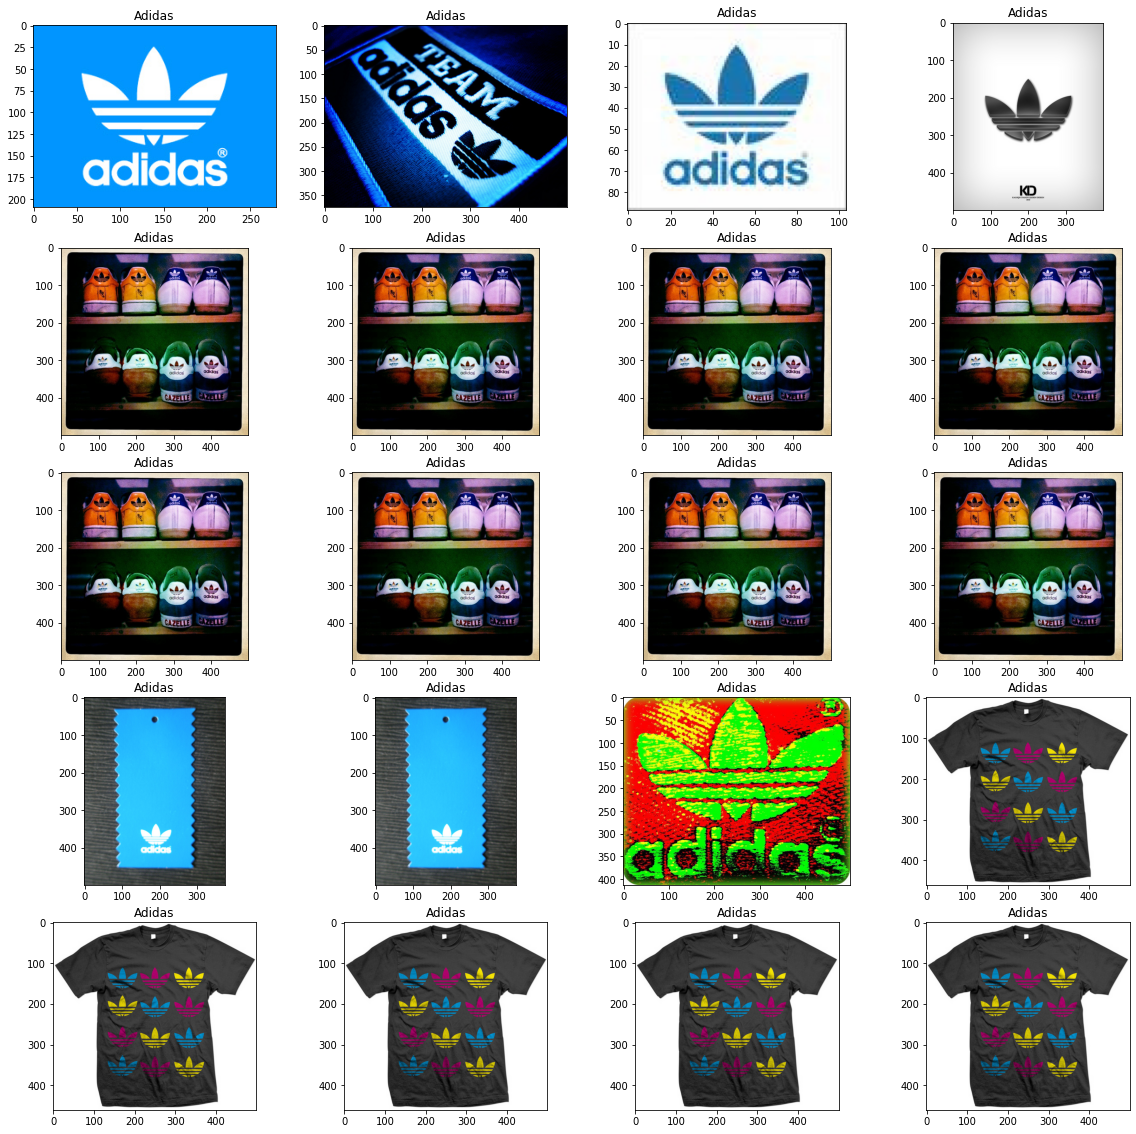

In [26]:
# Plot the image grid
plt.figure(figsize = (20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    img = cv2.imread(TRAIN_DIR + images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(labels[i])

In [29]:
train,test = train_test_split(train_csv,test_size=0.1, random_state=42)

In [30]:
print("shape of training data: ", train.shape)
print("shape of test data: ", test.shape)

shape of training data:  (4082, 2)
shape of test data:  (454, 2)


In [31]:
BATCH_SIZE   = 10
EPOCHS       = 100
TARGET_SIZE  = 240
num_features = 32
num_labels   = 27
batch_size   = 64

In [32]:
train_datagen = ImageDataGenerator(validation_split                = 0.2,
                                     preprocessing_function        = None,
                                     rotation_range                = 20,
                                     zoom_range                    = 0.2,
                                     cval                          = 0.1,
                                     horizontal_flip               = True,
                                     vertical_flip                 = True,
                                     fill_mode                     = "nearest",
                                     shear_range                   = 0.15,
                                     height_shift_range            = 0.15,
                                     width_shift_range             = 0.15,
                                     featurewise_center            = True,
                                     featurewise_std_normalization = True)

In [34]:
train_generator = train_datagen.flow_from_dataframe(train,
                         directory   = os.path.join(WORK_DIR, "images/"),
                         subset      = "training",
                         x_col       = "image",
                         y_col       = "Brand",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size  = BATCH_SIZE,
                         class_mode  = "sparse")


Found 3266 validated image filenames belonging to 27 classes.


In [35]:
validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                       directory    = os.path.join(WORK_DIR, "images/"),
                       subset       = "validation",
                       x_col        = "image",
                       y_col        = "Brand",
                       target_size  = (TARGET_SIZE, TARGET_SIZE),
                       batch_size   = BATCH_SIZE,
                       class_mode   = "sparse")

Found 816 validated image filenames belonging to 27 classes.


Found 1 validated image filenames belonging to 1 classes.


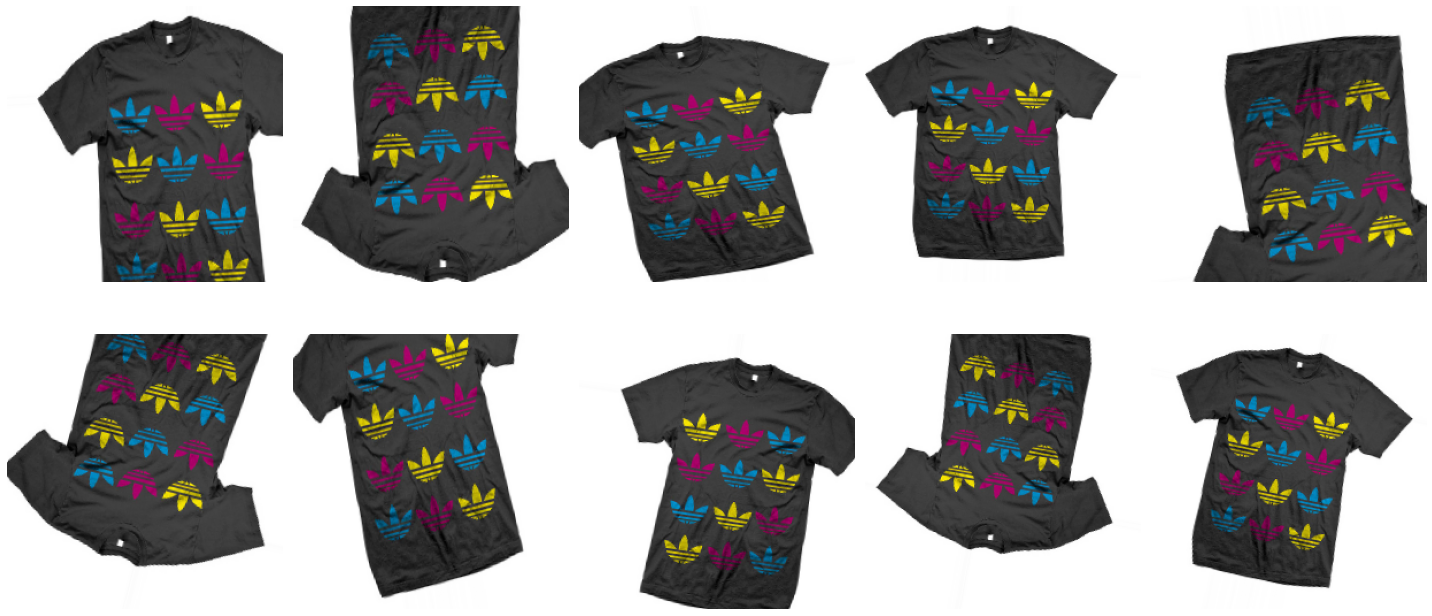

In [37]:
generator = train_datagen.flow_from_dataframe(train_csv.iloc[20:21],
                         directory     = os.path.join(WORK_DIR, "images/"),
                         x_col         = "image",
                         y_col         = "Brand",
                         target_size   = (TARGET_SIZE, TARGET_SIZE),
                         batch_size    = BATCH_SIZE,
                         class_mode    = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes  = plt.subplots(2, 5, figsize = (20, 10))
axes       = axes.flatten()

for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [38]:
ACCURACY_THRESHOLD = 0.9

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [39]:
# Loss curve
def lossCurve(history):
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

# accuracy curve
def accuracyCurve(history):
  plt.plot(history.history['acc'],'r',linewidth=3.0) 
  plt.plot(history.history['val_acc'],'b',linewidth=3.0) 
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
  plt.xlabel('Epochs ',fontsize=16) 
  plt.ylabel('Accuracy',fontsize=16) 
  plt.title('Accuracy Curves',fontsize=16)
    
# Curve gride
def plotSummary(history):
    plt.figure(figsize=[18,10]) 
    plt.subplot(121)
    # Model summary of loss and accuray during training with data
    lossCurve(history)
    #Plot the Accuracy Curves
    plt.subplot(122)
    accuracyCurve(history)

In [40]:
def CNN_model():
    model =  Sequential()    
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(TARGET_SIZE,TARGET_SIZE,3)))  #300,200
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [43]:
model = CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 238, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 119, 119, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 453152)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                29001792  
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [44]:
%%time 
history = model.fit( train_generator,epochs=5,verbose=1,validation_data = validation_generator,batch_size = BATCH_SIZE)

Epoch 1/5
327/327 [==============================] - 177s 542ms/step - loss: 28.1888 - acc: 0.0756 - val_loss: 7.1092 - val_acc: 0.0956
Epoch 2/5
327/327 [==============================] - 176s 537ms/step - loss: 3.3382 - acc: 0.0851 - val_loss: 11.9226 - val_acc: 0.0870
Epoch 3/5
 17/327 [>.............................] - ETA: 2:41 - loss: 3.2457 - acc: 0.0824

KeyboardInterrupt: 